# 02. Preprocessing and modelling

In [84]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# !pip install xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score # accepts only one metric
from sklearn.model_selection import cross_validate # accepts more than one metric 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Import the data after cleaning and EDA 

In [246]:
data = pd.read_csv("../01-Cleaning_and_EDA/data.csv")
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,is_renovated,year,month,weekday
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,0,2014,10,0
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,1,2014,12,1
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,0,2015,2,2
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,0,2014,12,1
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,0,2015,2,2


In [247]:
data.shape

(21597, 25)

In [248]:
drop_cols = pd.read_csv("../01-Cleaning_and_EDA/drop_cols.csv")
drop_cols = list(drop_cols["0"])
drop_cols

['id',
 'sqft_above',
 'sqft_basement',
 'condition',
 'yr_built',
 'zipcode',
 'long',
 'year',
 'month',
 'weekday',
 'sqft_lot',
 'bathrooms',
 'grade',
 'sqft_living15',
 'bedrooms',
 'sqft_lot15']

## Objective
A quick reminder: the goal is to predict the price of a property.

In [249]:
data["price"].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

## Linear regression
Start by creating a function to run model and a dictionary to store evaluation metrics
### Metrics used
- **R-squared (R2)**: This metric measures how well the model explains the variance in the data. Higher R2 values indicate a better fit.

- **Mean Squared Error (MSE)**: MSE measures the average squared difference between the predicted and actual values. Lower MSE values indicate better model performance.

- **Root Mean Squared Error (RMSE)**: RMSE is the square root of MSE and represents the average absolute error. Lower RMSE is better.

- **Mean Absolute Error (MAE)**: MAE measures the average absolute difference between predicted and actual values. Smaller MAE values are better.

In [250]:
def run_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model2 = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    scoring_metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
    cross_val_scores = cross_validate(model2, X_train, y_train, cv=10, scoring=scoring_metrics, error_score="raise")
    
    mean_r2_cv = round(np.mean(cross_val_scores["test_r2"]), 3)
    mean_mse_cv = round(-np.mean(cross_val_scores["test_neg_mean_squared_error"]), 3)  
    mean_mae_cv = round(-np.mean(cross_val_scores["test_neg_mean_absolute_error"]), 3)  
    rmse_cv = round(np.sqrt(mean_mse_cv), 3)
    
    
    metrics = {
        "Mean Squared Error (MSE)": mean_mse_cv,
        "Root Mean Squared Error (RMSE)": rmse_cv,
        "Mean Absolute Error (MAE)": mean_mae_cv,
        "R-squared (R2)": mean_r2_cv
    }
        
    return metrics

In [251]:
evaluation_results_linreg = {}

## Benchmark: no preprocessing, linear regression

In [252]:
# Drop the columns that we have created, date (because it's not numerical) and ID (high cardinality)
first_drop = ['id', 'date', 'is_renovated', 'year', 'month', 'weekday']
data = data.drop(first_drop, axis=1)
data.shape

(21597, 19)

In [253]:
# X-y split
X = data.drop("price", axis=1)
y = data["price"]
X.shape

(21597, 18)

In [254]:
# Apply linear regression
linreg = LinearRegression()
benchmark_metrics = run_model(linreg, X, y)

In [255]:
evaluation_results_linreg["Benchmark"] = benchmark_metrics
evaluation_results_linreg

{'Benchmark': {'Mean Squared Error (MSE)': 40817470368.741,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699}}

## Feature selection
We will take two approaches here, the first one removing only independent features that are correlated with each other, to remove multicollinearity, and also the features with a very low correlation with the target (close to 0). The second one will be more agressive, and we will remove also all features with small correlation with the target. <br>

We have already seen the correlation matrix in the previous notebook but we will display it here aswell for clarity.

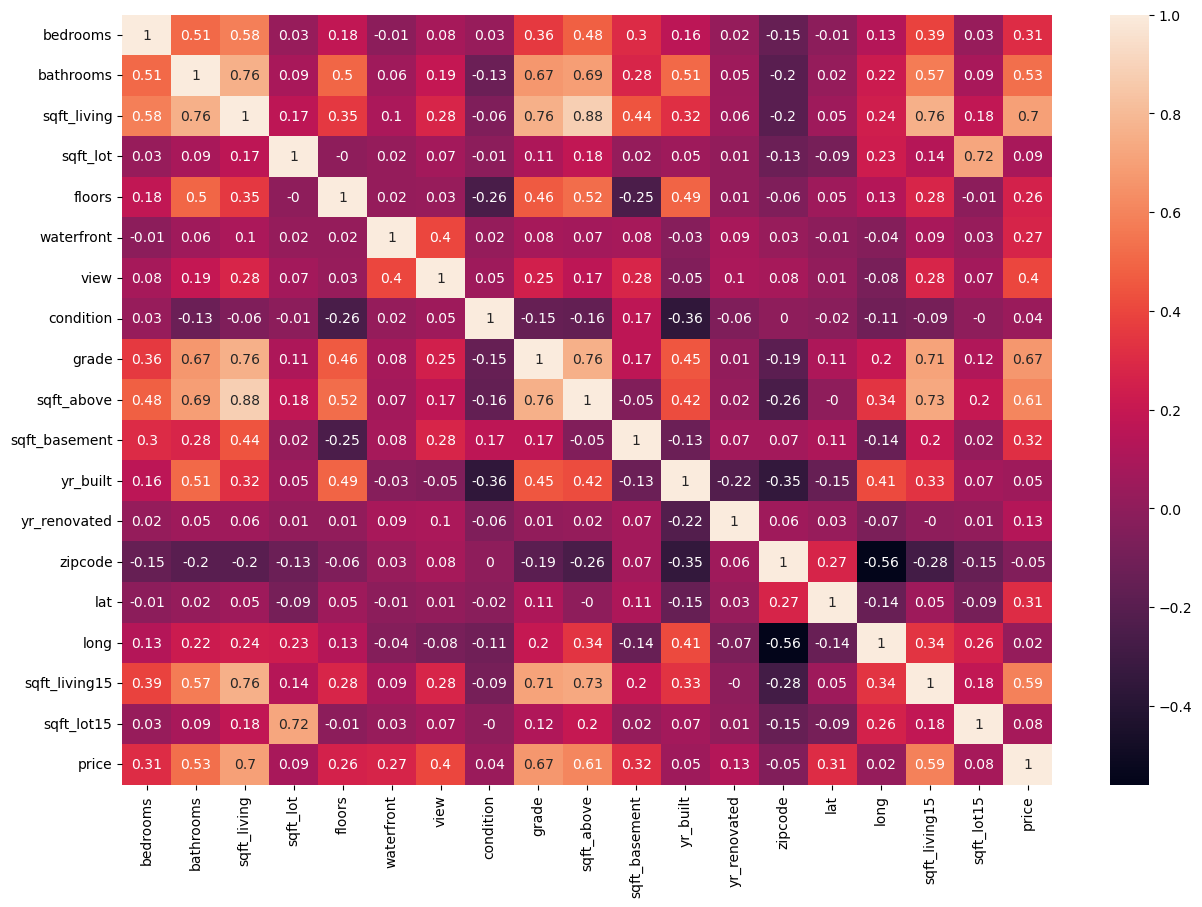

In [256]:
mask = np.zeros_like(data.corr())
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(round(data.corr(), 2), mask=mask, annot=True)
plt.show()

For the first approach, we will use the features identified in the Cleaning+EDA notebook

In [257]:
drop_cols_less = [col for col in drop_cols if col not in first_drop] # + ["is_renovated", "date"]
drop_cols_less

['sqft_above',
 'sqft_basement',
 'condition',
 'yr_built',
 'zipcode',
 'long',
 'sqft_lot',
 'bathrooms',
 'grade',
 'sqft_living15',
 'bedrooms',
 'sqft_lot15']

Second approach, remove also waterfront because its correlation with view (0.4), while keeping view because it has a higher correlation to price, and yr_renovated because its correlation with price is only 0.13.

In [258]:
drop_cols_more = drop_cols_less + ["waterfront", "yr_renovated"]

In [259]:
data.shape

(21597, 19)

In [260]:
data_removed_less = data.drop(drop_cols_less, axis=1)
data_removed_less.shape

(21597, 7)

In [261]:
data_removed_more = data.drop(drop_cols_more, axis=1)
data_removed_more.shape

(21597, 5)

In [262]:
# Linear regression with less feature removal
X = data_removed_less.drop("price", axis=1)
y = data_removed_less["price"]

metrics = run_model(linreg, X, y)

In [263]:
evaluation_results_linreg["Less feature removal"] = metrics
evaluation_results_linreg

{'Benchmark': {'Mean Squared Error (MSE)': 40817470368.741,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699},
 'Less feature removal': {'Mean Squared Error (MSE)': 50832404642.0,
  'Root Mean Squared Error (RMSE)': 225460.428,
  'Mean Absolute Error (MAE)': 142191.687,
  'R-squared (R2)': 0.625}}

In [264]:
# Linear regression with more feature removal
X = data_removed_more.drop("price", axis=1)
y = data_removed_more["price"]

metrics = run_model(linreg, X, y)

In [265]:
evaluation_results_linreg["More feature removal"] = metrics
evaluation_results_linreg

{'Benchmark': {'Mean Squared Error (MSE)': 40817470368.741,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699},
 'Less feature removal': {'Mean Squared Error (MSE)': 50832404642.0,
  'Root Mean Squared Error (RMSE)': 225460.428,
  'Mean Absolute Error (MAE)': 142191.687,
  'R-squared (R2)': 0.625},
 'More feature removal': {'Mean Squared Error (MSE)': 53419668901.721,
  'Root Mean Squared Error (RMSE)': 231126.954,
  'Mean Absolute Error (MAE)': 144977.599,
  'R-squared (R2)': 0.607}}

The results are worse with the feature removal. Let's try with a less agressive approach.

In [266]:
keep_cols = ['sqft_above', "bathrooms", "grade", "sqft_living15", "bedrooms"]
drop_cols_minimal = [x for x in drop_cols_less if x not in keep_cols]
drop_cols_minimal

['sqft_basement',
 'condition',
 'yr_built',
 'zipcode',
 'long',
 'sqft_lot',
 'sqft_lot15']

In [267]:
data_removed_minimal = data.drop(drop_cols_minimal, axis=1)
data_removed_minimal.shape

(21597, 12)

In [268]:
# Linear regression with minimal feature removal
X = data_removed_minimal.drop("price", axis=1)
y = data_removed_minimal["price"]

metrics = run_model(linreg, X, y)

In [269]:
evaluation_results_linreg["Minimal feature removal"] = metrics
evaluation_results_linreg

{'Benchmark': {'Mean Squared Error (MSE)': 40817470368.741,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699},
 'Less feature removal': {'Mean Squared Error (MSE)': 50832404642.0,
  'Root Mean Squared Error (RMSE)': 225460.428,
  'Mean Absolute Error (MAE)': 142191.687,
  'R-squared (R2)': 0.625},
 'More feature removal': {'Mean Squared Error (MSE)': 53419668901.721,
  'Root Mean Squared Error (RMSE)': 231126.954,
  'Mean Absolute Error (MAE)': 144977.599,
  'R-squared (R2)': 0.607},
 'Minimal feature removal': {'Mean Squared Error (MSE)': 46255928917.296,
  'Root Mean Squared Error (RMSE)': 215071.916,
  'Mean Absolute Error (MAE)': 134891.839,
  'R-squared (R2)': 0.659}}

## Scaling (continuous independent features)
We will use Standard Scaler it's more robust to outliers. Note for the future: try also Robust Scaler.

In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   bathrooms      21597 non-null  float64
 2   sqft_living    21597 non-null  int64  
 3   sqft_lot       21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  int64  
 6   view           21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  int64  
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  price 

In [271]:
data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [272]:
dataframes = [data, data_removed_minimal, data_removed_less, data_removed_more]
dataframes_names = ["data", "data_removed_minimal", "data_removed_less", "data_removed_more"]

# Select all the independent variables that are continuous for apply the scaling
continuous_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long',
                   'sqft_living15', 'sqft_lot15']

scaled_dataframes = {}  # Create an empty dictionary to store scaled dataframes

for i in range(0,4):
    df = dataframes[i]
    df_name = dataframes_names[i]
    
    continuous = [col for col in df.columns if col in continuous_cols]
    X_continuous = df[continuous]
    rest_df = df.drop(continuous, axis=1)
    X_continuous_scaled = StandardScaler().fit_transform(X_continuous)
    df_name = f"{df_name}_scaled"  
    scaled_df = pd.concat([pd.DataFrame(X_continuous_scaled, columns=continuous), rest_df], axis=1)
    scaled_dataframes[df_name] = scaled_df  # Store the scaled dataframe in the dictionary

In [273]:
data_scaled = scaled_dataframes["data_scaled"]
data_removed_minimal_scaled = scaled_dataframes["data_removed_minimal_scaled"]
data_removed_less_scaled = scaled_dataframes["data_removed_less_scaled"]
data_removed_more_scaled = scaled_dataframes["data_removed_more_scaled"]

In [274]:
dataframes_scaled = [data_scaled, data_removed_minimal_scaled, data_removed_less_scaled, data_removed_more_scaled]
dataframes_scaled_names = ["data_scaled", "data_removed_minimal_scaled", "data_removed_less_scaled", "data_removed_more_scaled"]

for i in range(0,4):
    X = dataframes_scaled[i].drop("price", axis=1)
    y = dataframes_scaled[i]["price"]

    metrics = run_model(linreg, X, y)
    
    evaluation_results_linreg[f"{dataframes_scaled_names[i]}"] = metrics

In [275]:
evaluation_results_linreg

{'Benchmark': {'Mean Squared Error (MSE)': 40817470368.741,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699},
 'Less feature removal': {'Mean Squared Error (MSE)': 50832404642.0,
  'Root Mean Squared Error (RMSE)': 225460.428,
  'Mean Absolute Error (MAE)': 142191.687,
  'R-squared (R2)': 0.625},
 'More feature removal': {'Mean Squared Error (MSE)': 53419668901.721,
  'Root Mean Squared Error (RMSE)': 231126.954,
  'Mean Absolute Error (MAE)': 144977.599,
  'R-squared (R2)': 0.607},
 'Minimal feature removal': {'Mean Squared Error (MSE)': 46255928917.296,
  'Root Mean Squared Error (RMSE)': 215071.916,
  'Mean Absolute Error (MAE)': 134891.839,
  'R-squared (R2)': 0.659},
 'data_scaled': {'Mean Squared Error (MSE)': 40817470368.739,
  'Root Mean Squared Error (RMSE)': 202033.34,
  'Mean Absolute Error (MAE)': 126760.691,
  'R-squared (R2)': 0.699},
 'data_removed_minimal_scaled': {'Mean Squared Error (MSE)': 4625592891

Without improvements with the scaling.

## Transformations for handling highly skewed distributions
As seen in the EDA step, the target (price) and the area related features are highly skewed. Although we won't apply transformations to the target, we will do so with the independent features.

In [276]:
dataframes = [data, data_removed_minimal, data_removed_less, data_removed_more]
dataframes_names = ["data", "data_removed_minimal", "data_removed_less", "data_removed_more"]

# Select the area related features
cols = data.columns.tolist()
sqft_columns = [col for col in cols if col.startswith("sqft")]

transformed_dataframes = {}  # Create an empty dictionary to store scaled dataframes

for i in range(0,4):
    df = dataframes[i]
    df_name = dataframes_names[i]
    
    cols_to_transform = [col for col in df.columns if col in sqft_columns]
    
    transformed_df = df.copy()
    transformed_df[cols_to_transform] = np.log1p(transformed_df[cols_to_transform])

    df_name = f"{df_name}_log_transformed"
    transformed_dataframes[df_name] = transformed_df  # Store the transformed dataframe in the dictionary

In [277]:
dataframes_transformed_names = list(transformed_dataframes.keys())

for name in dataframes_transformed_names:
    X = transformed_dataframes[name].drop("price", axis=1)
    y = transformed_dataframes[name]["price"]

    metrics = run_model(linreg, X, y)

    evaluation_results_linreg[name] = metrics

## Outlier removal (continuous features, independent and dependent)

In [278]:
continuous_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long',
                   'sqft_living15', 'sqft_lot15', 'price'] # price added

def remove_outliers(data, threshold=1.5, columns=[col for col in df.columns if col in continuous_cols], skip_columns=[]):
    for column in columns:
        if column not in skip_columns:
            upper = np.percentile(data[column], 75)
            lower = np.percentile(data[column], 25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            data = data[(data[column] > lower_limit) & (data[column] < upper_limit)]
    return data

outliers_removed_dataframes = {}

for i in range(0,4):
    df = dataframes[i]
    df_name = dataframes_names[i]
    df_no_outliers_with_target = remove_outliers(df, threshold=1.5, skip_columns=[])
    df_name = f"{df_name}_no_outliers_with_target"  
    outliers_removed_dataframes[df_name] = df_no_outliers_with_target

    df_name = dataframes_names[i]
    df_no_outliers_no_target = remove_outliers(df, threshold=1.5, skip_columns=[])
    df_name = f"{df_name}_no_outliers_no_target"  
    outliers_removed_dataframes[df_name] = df_no_outliers_no_target

In [279]:
list(outliers_removed_dataframes.keys())

['data_no_outliers_with_target',
 'data_no_outliers_no_target',
 'data_removed_minimal_no_outliers_with_target',
 'data_removed_minimal_no_outliers_no_target',
 'data_removed_less_no_outliers_with_target',
 'data_removed_less_no_outliers_no_target',
 'data_removed_more_no_outliers_with_target',
 'data_removed_more_no_outliers_no_target']

In [280]:
dataframes_outliers_names = list(outliers_removed_dataframes.keys())

for name in dataframes_outliers_names:
    X = outliers_removed_dataframes[name].drop("price", axis=1)
    y = outliers_removed_dataframes[name]["price"]

    metrics = run_model(linreg, X, y)

    evaluation_results_linreg[name] = metrics

In [281]:
df_linear_regression = pd.DataFrame(evaluation_results_linreg).T
df_linear_regression.to_csv("df_linear_regression.csv", index=False)

In [282]:
df_linear_regression

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Benchmark,4.081747e+10,202033.340,126760.691,0.699
Less feature removal,5.083240e+10,225460.428,142191.687,0.625
More feature removal,5.341967e+10,231126.954,144977.599,0.607
Minimal feature removal,4.625593e+10,215071.916,134891.839,0.659
data_scaled,4.081747e+10,202033.340,126760.691,0.699
data_removed_minimal_scaled,4.625593e+10,215071.916,134891.839,0.659
data_removed_less_scaled,5.083240e+10,225460.428,142191.687,0.625
data_removed_more_scaled,5.341967e+10,231126.954,144977.599,0.607
data_log_transformed,4.553600e+10,213391.667,131411.572,0.665
data_removed_minimal_log_transformed,5.255987e+10,229259.391,141854.057,0.614


Despite applying several preprocessing techniques, there is no improvement in the results when compared with the benchmark. <br>
We will try other algorithms to see if we can improve the results.

## Random Forest

In [38]:
dataframes = [data, data_removed_minimal, data_removed_less, data_removed_more]
dataframes_names = ["data", "data_removed_minimal", "data_removed_less", "data_removed_more"]

evaluation_results_random_forest = {}

In [39]:
for i, df in enumerate(dataframes):
    df_name = dataframes_names[i]
    
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    rf_regressor = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=rf_regressor,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5)

    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and obtain best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    evaluation_results_random_forest[df_name] = {
        "Best Hyperparameters": best_params,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (R2)": r2
    }

In [41]:
df_random_forest = pd.DataFrame(evaluation_results_random_forest).T
df_random_forest

,Best Hyperparameters,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
data,"{'max_depth': 20, 'max_features': 'auto', 'min...",15440013134.291182,124257.849387,67710.441124,0.881428
data_removed_minimal,"{'max_depth': 20, 'max_features': 'auto', 'min...",25140814649.751835,158558.552749,86601.253894,0.80693
data_removed_less,"{'max_depth': 10, 'max_features': 'auto', 'min...",31907909490.422165,178627.851945,101190.782609,0.754962
data_removed_more,"{'max_depth': 10, 'max_features': 'auto', 'min...",33421190261.584225,182814.633609,101991.482719,0.743341


There is a clear improvement when compared with the linear regression metrics, but we still find that the best results are obtained without feature selection. For the next iteration, we will use only the "data" dataframe with different preprocessing techniques.  

In [42]:
data_log_transformed = transformed_dataframes['data_log_transformed']
data_no_outliers_with_target = outliers_removed_dataframes['data_no_outliers_with_target']
data_no_outliers_no_target = outliers_removed_dataframes['data_no_outliers_no_target']

dataframes = [data_scaled, data_log_transformed, data_no_outliers_with_target, data_no_outliers_no_target]
dataframes_names = ["data_scaled", "data_log_transformed", "data_no_outliers_with_target", "data_no_outliers_no_target"]


for i, df in enumerate(dataframes):
    df_name = dataframes_names[i]
    
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    rf_regressor = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=rf_regressor,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5)

    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and obtain best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    evaluation_results_random_forest[df_name] = {
        "Best Hyperparameters": best_params,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (R2)": r2
    }

In [46]:
df_random_forest = pd.DataFrame(evaluation_results_random_forest).T
df_random_forest

,Best Hyperparameters,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
data,"{'max_depth': 20, 'max_features': 'auto', 'min...",15440013134.291182,124257.849387,67710.441124,0.881428
data_removed_minimal,"{'max_depth': 20, 'max_features': 'auto', 'min...",25140814649.751835,158558.552749,86601.253894,0.80693
data_removed_less,"{'max_depth': 10, 'max_features': 'auto', 'min...",31907909490.422165,178627.851945,101190.782609,0.754962
data_removed_more,"{'max_depth': 10, 'max_features': 'auto', 'min...",33421190261.584225,182814.633609,101991.482719,0.743341
data_scaled,"{'max_depth': None, 'max_features': 'auto', 'm...",15475972557.836798,124402.462025,67738.720246,0.881152
data_log_transformed,"{'max_depth': 20, 'max_features': 'auto', 'min...",15475656004.288292,124401.189722,67756.606738,0.881154
data_no_outliers_with_target,"{'max_depth': 20, 'max_features': 'auto', 'min...",5496030109.014114,74135.21504,51703.169116,0.864638
data_no_outliers_no_target,"{'max_depth': 20, 'max_features': 'auto', 'min...",5496030109.014114,74135.21504,51703.169116,0.864638


- **data**: This model has the highest R-squared (0.88), indicating that it explains a significant portion of the variance in house prices. The Root Mean Squared Error (RMSE) of approximately 124,257 suggests that, on average, predictions are off by about 124,257 dollars, which is relatively reasonable considering the range of house prices. The Mean Absolute Error (MAE) of approximately 67,710 dollars indicates the average absolute difference between predicted and actual prices.

- **data_removed_minimal, data_removed_less, data_removed_more**: Removing features results in decrease of performance. R-squared drops to 0.74, indicating that the removed features might have contained valuable information for predictions. RMSE and MAE increase, signifying less accurate predictions.

- **data_scaled**: Scaling the data without feature removal performs similarly to the original 'data' scenario. R-squared is 0.88, and RMSE and MAE are comparable, indicating that scaling alone doesn't significantly impact model performance.

- **data_log_transformed**: Log-transforming the data also performs similarly to the original 'data' scenario. R-squared is 0.88, and RMSE and MAE are comparable, indicating that this transformation alone doesn't significantly impact model performance.

- **data_no_outliers_with_target, data_no_outliers_no_target**: These models perform exactly the same, indicating that removing or maintaining outliers in price has no effect in the performance. They perform well, with R-squared values of 0.86. They show lower RMSE and MAE compared to other scenarios, indicating that removing outliers is beneficial for model accuracy. 

The R-squared is higher in "data" but RMSE and MAE are lower in "data_no_outliers_with_target" and "data_no_outliers_no_target". This means that the "data" model explains a larger portion of the variance in house prices, while the other models have a better accuracy. <br>

We could use the "data" model for exploratory analysis and understanding feature importance, and then use the "data_no_outliers_with_target" or "data_no_outliers_no_target" models for actual price predictions in a real-world application. 

In [55]:
evaluation_results_random_forest["data"]["Best Hyperparameters"]

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

### Feature importance
As indicated above, we will use the "data" model since it has the highest R-squared.

In [60]:
# Train the "data" model
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(max_depth=20, max_features='auto', 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     n_estimators=300, random_state=42)

rf_model.fit(X_train, y_train)

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Store feature names and their importances in a df 
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [61]:
feature_importance_df

,Feature,Importance
8,grade,0.304511
2,sqft_living,0.278604
14,lat,0.160287
15,long,0.069566
5,waterfront,0.033305
16,sqft_living15,0.031290
11,yr_built,0.025969
9,sqft_above,0.022743
3,sqft_lot,0.013891
17,sqft_lot15,0.013300


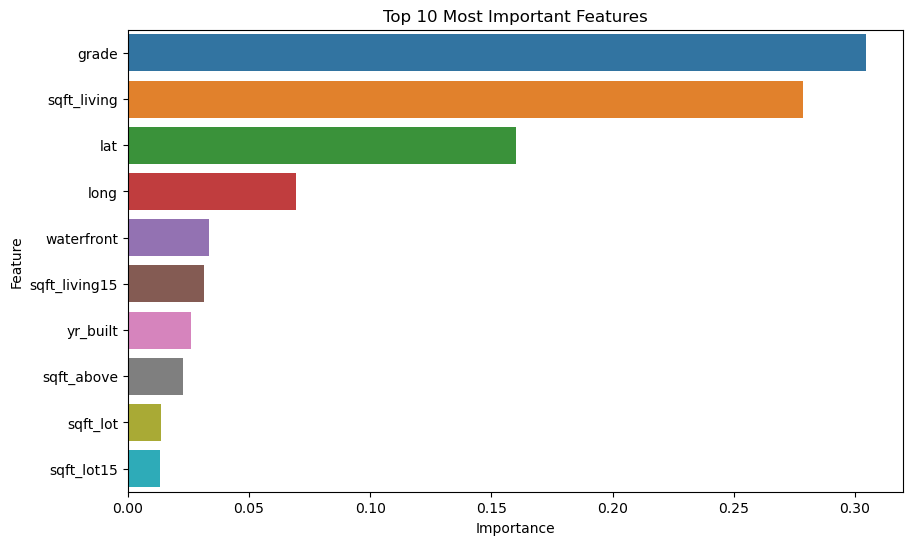

In [69]:
# Top 10 most important features
N = 10  
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(N))
plt.title(f'Top {N} Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Top five features: 

- **Grade (0.30)**: The quality of a house has the most significant impact on price predictions.

- **Living Space (0.28)**: The square footage of the living area is the second most important factor.

- **Latitude (0.16)**: Location matters, with latitude influencing property values.

- **Longitude (0.07)**: Longitude also plays a role but to a lesser extent.

- **Waterfront View (0.03)**: Homes with waterfront views tend to have higher prices.

The top five features - grade, square footage of living space, latitude, longitude, and waterfront status - have the most significant impact on house prices. The remaining features play a relatively smaller role in determining property values, with some, like the number of bedrooms, floors, and renovation year, having minimal influence.

### Feature selection 
#### Using only the most important features

In [72]:
selected_features = ['grade', 'sqft_living', 'lat', 'long', 'waterfront']

X_selected = X[selected_features]

X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_selected, y_train)

# Get the best hyperparameters and obtain best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_results_random_forest["data_most_important"] = {
    "Best Hyperparameters": best_params,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Error (MAE)": mae,
    "R-squared (R2)": r2
}

#### Removing low importance features

In [74]:
low_importance_threshold = 0.01
high_importance_features = [feature for feature, importance in zip(X.columns, rf_model.feature_importances_) 
                            if importance >= low_importance_threshold]

X_high_importance = X[high_importance_features]

X_train_high_importance, X_test_high_importance, y_train, y_test = train_test_split(X_high_importance, y, test_size=0.2, random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

grid_search.fit(X_train_high_importance, y_train)

# Get the best hyperparameters and obtain best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_high_importance)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_results_random_forest["data_least_important_removed"] = {
    "Best Hyperparameters": best_params,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Error (MAE)": mae,
    "R-squared (R2)": r2
}

In [87]:
df_random_forest = pd.DataFrame(evaluation_results_random_forest).T
df_random_forest.to_csv("df_random_forest.csv", index=False)

In [88]:
df_random_forest

,Best Hyperparameters,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
data,"{'max_depth': 20, 'max_features': 'auto', 'min...",15440013134.291182,124257.849387,67710.441124,0.881428
data_removed_minimal,"{'max_depth': 20, 'max_features': 'auto', 'min...",25140814649.751835,158558.552749,86601.253894,0.80693
data_removed_less,"{'max_depth': 10, 'max_features': 'auto', 'min...",31907909490.422165,178627.851945,101190.782609,0.754962
data_removed_more,"{'max_depth': 10, 'max_features': 'auto', 'min...",33421190261.584225,182814.633609,101991.482719,0.743341
data_scaled,"{'max_depth': None, 'max_features': 'auto', 'm...",15475972557.836798,124402.462025,67738.720246,0.881152
data_log_transformed,"{'max_depth': 20, 'max_features': 'auto', 'min...",15475656004.288292,124401.189722,67756.606738,0.881154
data_no_outliers_with_target,"{'max_depth': 20, 'max_features': 'auto', 'min...",5496030109.014114,74135.21504,51703.169116,0.864638
data_no_outliers_no_target,"{'max_depth': 20, 'max_features': 'auto', 'min...",5496030109.014114,74135.21504,51703.169116,0.864638
data_most_important,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",18149980033.968857,134721.861752,74783.466849,0.860617
data_least_important_removed,"{'max_depth': None, 'max_features': 'sqrt', 'm...",16347540868.611135,127857.502199,70135.763309,0.874459


There has not been an improvement in the results by using only the most important features, or by removing the least important features.

## XGBoost

In [48]:
dataframes = [data, data_scaled, data_log_transformed, data_no_outliers_with_target, data_no_outliers_no_target]
dataframes_names = ["data", "data_scaled", "data_log_transformed", "data_no_outliers_with_target", "data_no_outliers_no_target"]

evaluation_results_xgboost = {}

In [75]:
for i, df in enumerate(dataframes):
    df_name = dataframes_names[i]
    
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_regressor = XGBRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=xgb_regressor,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5)

    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters to obtain the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    evaluation_results_xgboost[df_name] = {
        "Best Hyperparameters": best_params,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (R2)": r2
    }

In [94]:
df_xgboost = pd.DataFrame(evaluation_results_xgboost).T
df_xgboost.to_csv("df_xgboost.csv", index=False)

In [83]:
df_xgboost

,Best Hyperparameters,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
data,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",14269922805.293348,119456.782165,64848.466685,0.890414
data_scaled,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",14141208415.588268,118916.813006,65415.221257,0.891402
data_log_transformed,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",14162416851.752436,119005.95301,65118.3571,0.891239
data_no_outliers_with_target,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",4903428626.631843,70024.485908,49505.592558,0.879233
data_no_outliers_no_target,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",4903428626.631843,70024.485908,49505.592558,0.879233


The best result seem to be obtained with "data_log_transformed". The R2 value is similar to the "data" dataset, which is the highest among the options. Additionally, it has lower RMSE and MAE compared to "data", indicating better predictive performance. We will move further with "data_log_transformed" and perform fine-tuning of the hyperparameters.

In [91]:
X = data_log_transformed.drop('price', axis=1)
y = data_log_transformed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Define the parameter grid for fine-tuning
param_grid = {
    'n_estimators': [250, 300, 350],   
    'max_depth': [4, 5, 6],  
    'learning_rate': [0.05, 0.1, 0.15],   
    'subsample': [0.7, 0.8, 0.9],   
    'colsample_bytree': [0.7, 0.8, 0.9]   
}

xgb_regressor = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_regressor,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  
                           cv=5)

grid_search.fit(X_train, y_train)

# Get the best hyperparameters to obtain the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_results_xgboost["data_log_transformed_fine_tuning"] = {
    "Best Hyperparameters": best_params,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Error (MAE)": mae,
    "R-squared (R2)": r2
}

In [95]:
df_xgboost = pd.DataFrame(evaluation_results_xgboost).T
df_xgboost.to_csv("df_random_forest.csv", index=False)

In [96]:
df_xgboost

,Best Hyperparameters,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
data,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",14269922805.293348,119456.782165,64848.466685,0.890414
data_scaled,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",14141208415.588268,118916.813006,65415.221257,0.891402
data_log_transformed,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",14162416851.752436,119005.95301,65118.3571,0.891239
data_no_outliers_with_target,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",4903428626.631843,70024.485908,49505.592558,0.879233
data_no_outliers_no_target,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",4903428626.631843,70024.485908,49505.592558,0.879233
data_log_transformed_fine_tuning,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",15032948856.416124,122608.926496,64413.795133,0.884554


Based on these results, the initial hyperparameter tuning with the "data_log_transformed" dataset produced a slightly better-performing model in terms of RMSE and R2. We will choose the initial set of hyperparameters, however, the difference in performance between the two sets of hyperparameters is relatively small. 

In [137]:
evaluation_results_xgboost["data_log_transformed"]["Best Hyperparameters"]

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'subsample': 0.8}

## Recap: best models obtained
### Linear regression
The best result obtained with Linear Regression was with virtually no preprocessing. Only the id and date features were dropped.

In [131]:
final_results = {}

<Axes: xlabel='price'>

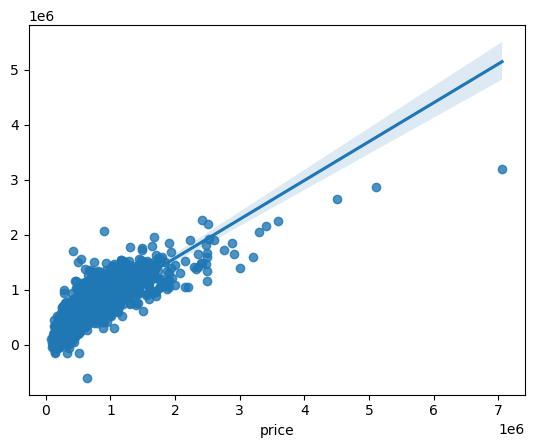

In [180]:
# Train the model and generate predictions
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg_model = LinearRegression()

linreg_model.fit(X_train, y_train)
y_pred = linreg_model.predict(X_test)

# Evaluate the model with cross validation
scoring_metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
cross_val_scores = cross_validate(linreg_model, X_train, y_train, cv=10, scoring=scoring_metrics, error_score="raise")

mean_r2_cv = round(np.mean(cross_val_scores["test_r2"]), 3)
mean_mse_cv = round(-np.mean(cross_val_scores["test_neg_mean_squared_error"]), 3) 
mean_mae_cv = round(-np.mean(cross_val_scores["test_neg_mean_absolute_error"]), 3) 
rmse_cv = np.sqrt(mean_mse_cv)

final_results["Linear Regression"] = {
    "Mean Squared Error (MSE)": mean_mse_cv,
    "Root Mean Squared Error (RMSE)": rmse_cv,
    "Mean Absolute Error (MAE)": mean_mae_cv,
    "R-squared (R2)": mean_r2_cv
}

sns.regplot(x = y_test, y = y_pred)

In [242]:
final_results["Linear Regression"]

{'Mean Squared Error (MSE)': 40817470368.741,
 'Root Mean Squared Error (RMSE)': 202033.33974555042,
 'Mean Absolute Error (MAE)': 126760.691,
 'R-squared (R2)': 0.699}

### Random Forest
The best result was obtained with the same dataframe and the following hyperparameters: <br>
- 'max_depth': 20
- 'max_features': 'auto'
- 'min_samples_leaf': 1
- 'min_samples_split': 2
- 'n_estimators': 300

<Axes: xlabel='price'>

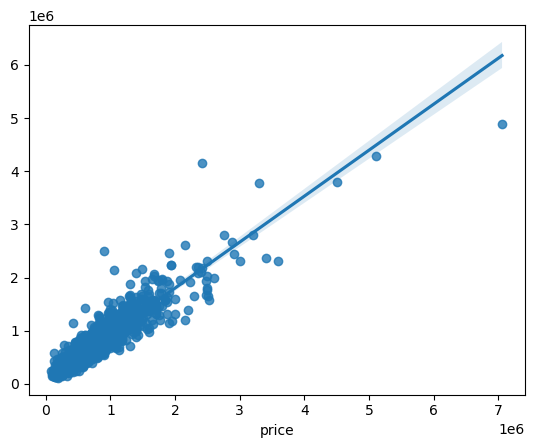

In [181]:
# Train the model and generate predictions
rf_model = RandomForestRegressor(max_depth=20, max_features='auto', 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     n_estimators=300, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate the model with cross validation
scoring_metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
cross_val_scores = cross_validate(rf_model, X_train, y_train, cv=10, scoring=scoring_metrics, error_score="raise")

mean_r2_cv = round(np.mean(cross_val_scores["test_r2"]), 3)
mean_mse_cv = round(-np.mean(cross_val_scores["test_neg_mean_squared_error"]), 3) 
mean_mae_cv = round(-np.mean(cross_val_scores["test_neg_mean_absolute_error"]), 3) 
rmse_cv = np.sqrt(mean_mse_cv)

final_results["Random Forest"] = {
    "Mean Squared Error (MSE)": mean_mse_cv,
    "Root Mean Squared Error (RMSE)": rmse_cv,
    "Mean Absolute Error (MAE)": mean_mae_cv,
    "R-squared (R2)": mean_r2_cv
}

sns.regplot(x = y_test, y = y_pred)

### XGBoost
The best results in these case were obtained with the "data" dataframe (basically no feature selection), where we log transformed the continuous independent variables ('sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15' and 'sqft_lot15'). The following hyperparameters were found to be the best:
- 'colsample_bytree': 0.8
- 'learning_rate': 0.1
- 'max_depth': 5
- 'n_estimators': 300
- 'subsample': 0.8

<Axes: xlabel='price'>

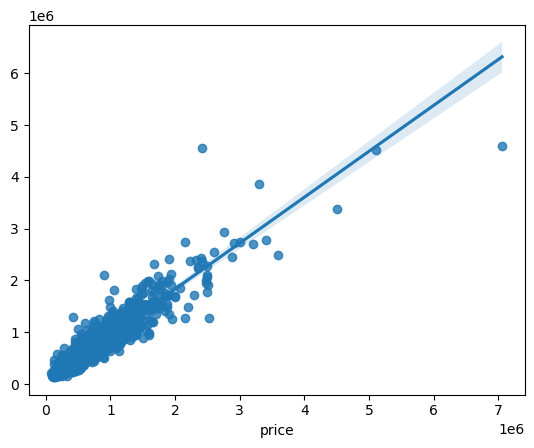

In [182]:
# Train the model and generate predictions
X = data_log_transformed.drop('price', axis=1)
y = data_log_transformed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=5, 
                             n_estimators=300, subsample=0.8, random_state=42)

xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model with cross validation
scoring_metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
cross_val_scores = cross_validate(xgb_regressor, X_train, y_train, cv=10, scoring=scoring_metrics, error_score="raise")

mean_r2_cv = round(np.mean(cross_val_scores["test_r2"]), 3)
mean_mse_cv = round(-np.mean(cross_val_scores["test_neg_mean_squared_error"]), 3) 
mean_mae_cv = round(-np.mean(cross_val_scores["test_neg_mean_absolute_error"]), 3) 
rmse_cv = np.sqrt(mean_mse_cv)

final_results["XGBoost"] = {
    "Mean Squared Error (MSE)": mean_mse_cv,
    "Root Mean Squared Error (RMSE)": rmse_cv,
    "Mean Absolute Error (MAE)": mean_mae_cv,
    "R-squared (R2)": mean_r2_cv
}

sns.regplot(x = y_test, y = y_pred)

In [183]:
df_final_results = pd.DataFrame(final_results).T
df_final_results.to_csv("df_final_results.csv", index=False)
df_final_results

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Linear Regression,4.081747e+10,202033.339746,126760.691,0.699
Random Forest,1.666581e+10,129096.136696,69364.999,0.877
XGBoost,1.387033e+10,117772.383900,65591.111,0.898


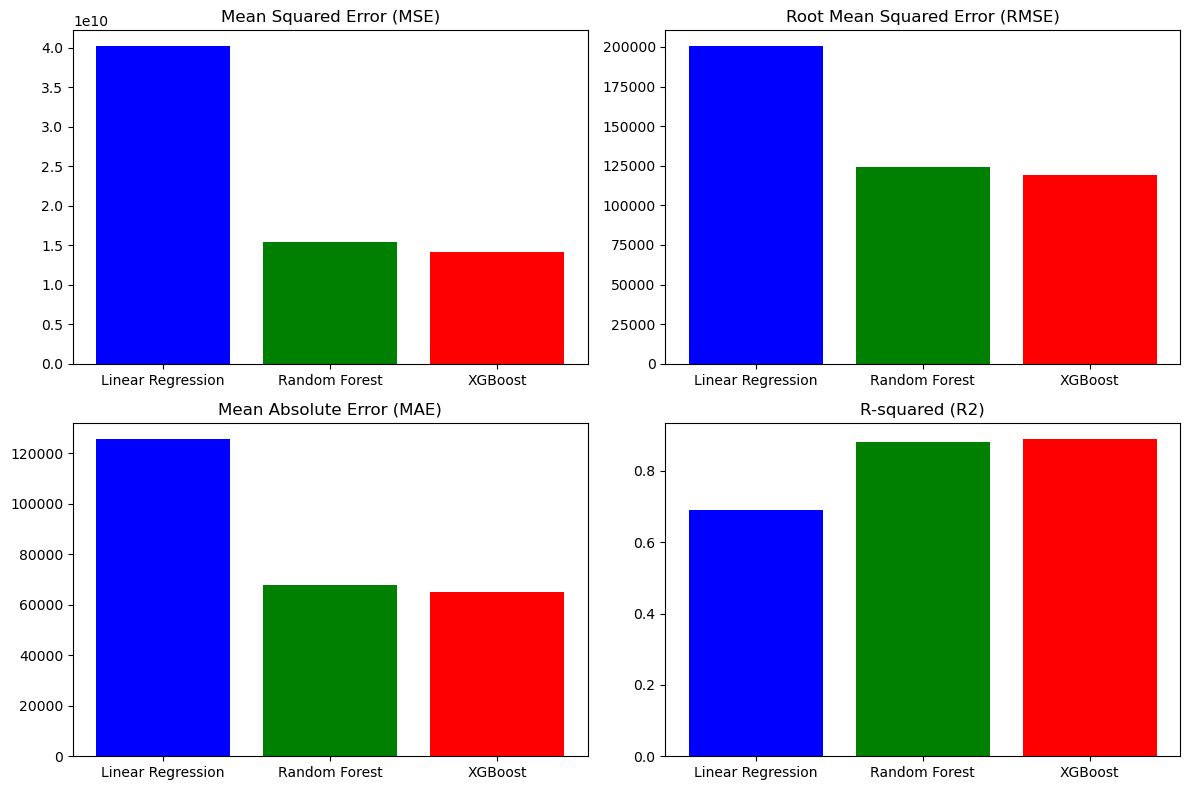

In [184]:
# Results
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mse = [40182718832.85, 15440013134.29, 14162416851.75]
rmse = [200456.28, 124257.85, 119005.95]
mae = [125739.84, 67710.44, 65118.36]
r2 = [0.69, 0.88, 0.89]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot Mean Squared Error
axes[0, 0].bar(models, mse, color=['blue', 'green', 'red'])
axes[0, 0].set_title('Mean Squared Error (MSE)')

# Plot Root Mean Squared Error
axes[0, 1].bar(models, rmse, color=['blue', 'green', 'red'])
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')

# Plot Mean Absolute Error
axes[1, 0].bar(models, mae, color=['blue', 'green', 'red'])
axes[1, 0].set_title('Mean Absolute Error (MAE)')

# Plot R-squared (R2)
axes[1, 1].bar(models, r2, color=['blue', 'green', 'red'])
axes[1, 1].set_title('R-squared (R2)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The metrics suggest that both Random Forest and XGBoost regression models outperform Linear Regression in predicting property prices. <br>

XGBoost obtained the best performance, with the lowest RMSE and MAE, indicating it provides the most accurate predictions. Its R-squared value of almost 0.9 indicates a strong fit to the data. The RMSE shows that, on average, predictions are off by approximately 118,000 dollars. <br>

We will now compare the model evaluation metrics with characteristics of the target variable to assess the performance of the model. 

In [191]:
data["price"].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

#### RMSE vs standard deviation
Helps to assess whether the model's errors are significant relative to the natural variability of prices in the dataset.

In [192]:
std_deviation_price = data["price"].std()
rmse = final_results["XGBoost"]["Root Mean Squared Error (RMSE)"]

round((rmse/std_deviation_price * 100), 2)

32.06

#### MAE vs mean 
MAE measures the average absolute difference between predicted and actual values. If MAE is small compared to the mean, it suggests that, on average, your model's predictions are close to the mean price.

In [194]:
avg_price = data["price"].mean()
mae = final_results["XGBoost"]["Mean Absolute Error (MAE)"]

round((mae/avg_price * 100), 2)

12.14

- RMSE vs standard deviation: On average, the model's predictions deviate from actual prices by 32.06% of the price variability. Lower values are better; further improvement would be needed for precise pricing.

- MAE vs mean: The model's predictions differ from actual prices by 12.14% of the mean price, indicating good overall accuracy without significant bias.

The difference between the two interpretations lies in how the two metrics handle errors. RMSE emphasizes larger errors (squaring errors penalizes outliers more heavily), while MAE treats all errors equally and does not emphasize outliers. <br>

The combination of a high RMSE and a low MAE suggests that your model performs reasonably well for the majority of cases but struggles with a few instances where the predictions have significant deviations from the actual prices. 

This is consistent with the regplot:

<Axes: xlabel='price'>

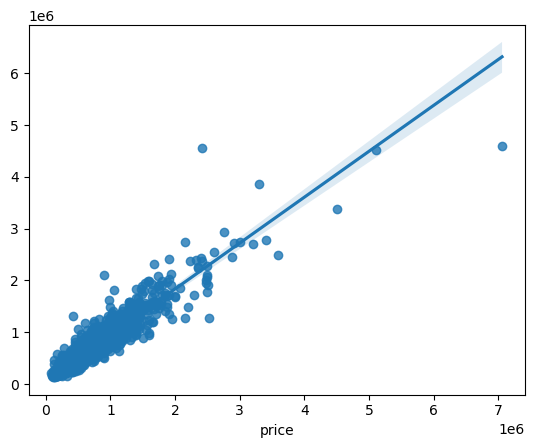

In [195]:
sns.regplot(x = y_test, y = y_pred)

#### Residual analysis 

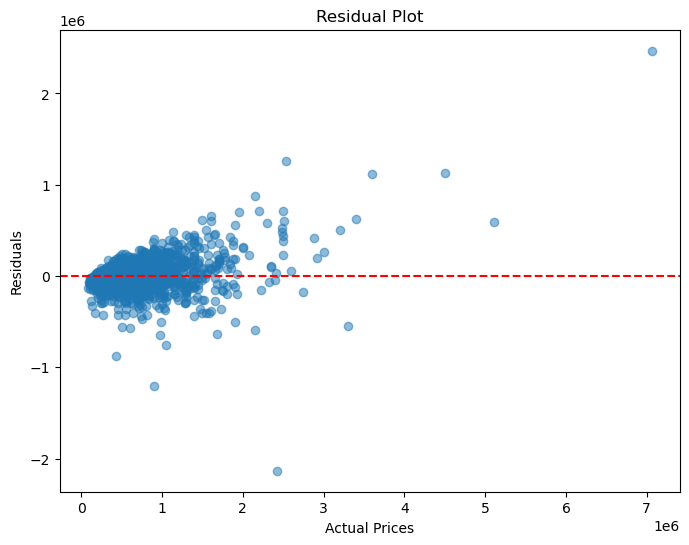

In [283]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

It seems like the residuals tend to be larger and positive in higher prices (above 1 million), indicating that the model overestimates high prices.

## Next steps for further improvement
- Handle outliers more effectively.
- Try combining preprocessing techniques to see how it affects the model performance.
- Further preprocessing and feature engineering.
- Different train-test split: we have used 80%-20%, try with 70%-30%, etc.
- Use other algorithms like RANSAC and Huber Regression, which are more robust to outliers.
- Explore the possibility of developing two different models: one for higher value properties (above 1 million) and other for the vast majority of properties, with a price under 1 million dollars. See below the distribution of price. This would probably allow us to have a much better predictive performance by reducing the variability of the target.

In [204]:
print(f"Percentage of properties with value below 1 million: {round(len(data[data['price']<1000000])/len(data) * 100, 2)} %")

Percentage of properties with value below 1 million: 93.1 %


<Axes: xlabel='price', ylabel='Count'>

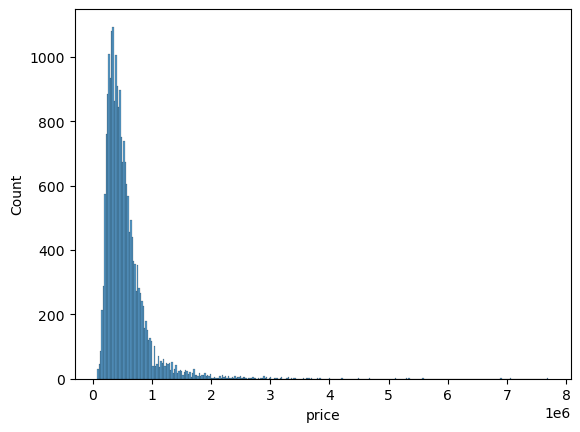

In [196]:
sns.histplot(data["price"])